## Supporting Code for Richter's Predictor

In [34]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white') # for plot styling

#sklearn imports 
#preprocessing and cross validation
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
#classification models
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#performance metrics
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,roc_curve,auc


### Data import

In [3]:
# read from the training data file
features = pd.read_csv("train_values.csv", index_col = 'building_id')
target = pd.read_csv("train_labels.csv",index_col = 'building_id')

### Seaborn pairplot

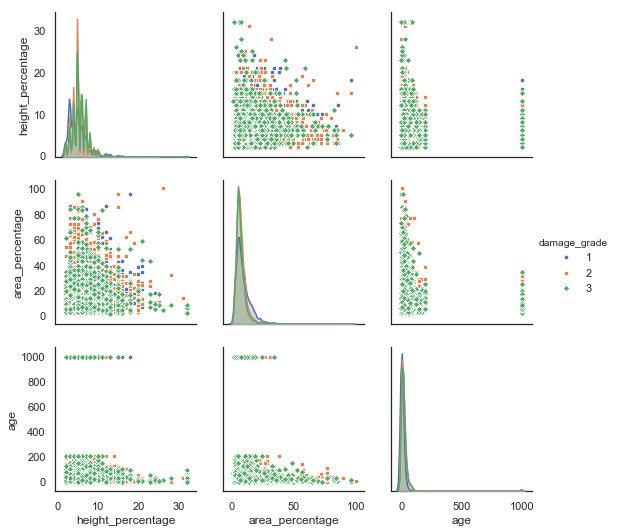

In [58]:
%matplotlib inline
sns.set_style('white')
#select features to pairplot
selected = ['height_percentage',
            'area_percentage',
            'age']

# sns.pairplot(features.join(target.astype('category')), 
#              hue = 'damage_grade',
#              vars = selected,
#              markers=["o", "s", "D"],
#              plot_kws={"s": 20}
#             )
#need to fix the overlapping by adding zitter or translucency to the scattters

### Seaborn violinplot and catplot

In [20]:
# sns.violinplot(x="damage_grade", y="count_floors_pre_eq", 
#                data=features.join(target.astype('category')))
sns.catplot(x="foundation_type", y="height_percentage", 
                hue="damage_grade",
                data=features.join(target.astype('category')), kind="box")
plt.ylim(-10,40)
plt.close()

### Plot continuous variables by different damage levels

In [26]:
%matplotlib inline
sns.set_style('white')

#explore geo_level distribution for different damage levels
var = 'geo_level_1_id'

#masks for different damage grades
mask1 = target['damage_grade']==1
mask2 = target['damage_grade']==2
mask3 = target['damage_grade']==3

#number of bins
n_bins = 31
fig1 = plt.figure()

#distribution of structure swith damage grade=1
ax1 = fig1.add_subplot(2,2,1)
ax1.hist(features[mask1][var], bins = n_bins, color = 'green')
ax1.set_title('damage grade = 1 (low)')

#distribution of structure swith damage grade=2
ax2 = fig1.add_subplot(2,2,2)
ax2.hist(features[mask2][var], bins = n_bins, color = 'orange')
ax2.set_title('damage grade = 2 (moderate)')

#distribution of structure swith damage grade=3
ax3 = fig1.add_subplot(2,2,3)
ax3.hist(features[mask3][var], bins = n_bins, color = 'red')
ax3.set_title('damage grade = 3 (high)')

#distribution of structure swith damage grade=3
ax3 = fig1.add_subplot(2,2,4)
ax3.hist(features[var], bins = n_bins, color = 'blue')
ax3.set_title('all')

#set size and show plots
fig1.set_size_inches(8, 8)
fig1.suptitle(var, fontsize=16)
plt.close(fig1)

### Plot variables variables by different damage levels

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('white')
#explore geo_level distribution for different damage levels
var = 'plan_configuration'

#masks for different damage grades
mask1 = (target['damage_grade']==1) 
mask2 = (target['damage_grade']==2) 
mask3 = (target['damage_grade']==3) 
#number of bins
n_bins = 30
fig = plt.figure()

#distribution of structure swith damage grade=1
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('damage grade = 1 (low)')
sns.countplot(features[mask1][var], 
              color = 'green',
              order = features[var].value_counts().index,
              ax = ax1
             )

#distribution of structure swith damage grade=2
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('damage grade = 2 (moderate)')
sns.countplot(features[mask2][var], 
              color = 'orange',
              order = features[var].value_counts().index,
              ax = ax2)

#distribution of structure swith damage grade=3
ax3 = fig.add_subplot(2,2,3)
ax3.set_title('damage grade = 3 (high)')
sns.countplot(features[mask3][var], 
              color = 'red', 
              ax = ax3,
              order = features[var].value_counts().index)

#distribution of structure swith damage grade=3
ax4 = fig.add_subplot(2,2,4)
ax4.set_title('all')
sns.countplot(features[var], 
              color = 'blue', 
              ax = ax4,
             order = features[var].value_counts().index)

#set size and show plots
fig.set_size_inches(8, 8)
fig.suptitle(var, fontsize=16)
plt.close(fig)

## Feature Engineering

In [ ]:
def design_matrix(features):
    #continuous features of interest
    con = [
           'geo_level_1_id',
           'geo_level_2_id', 
           'geo_level_3_id',
           'count_floors_pre_eq',
           'age',                 
           'area_percentage',
           'height_percentage',
           'count_families',
#            'legal_ownership_status' 
          ]
    X_con = features[con]
    
    #scale continuous features for Multinomial classifier
    scaler = pp.MinMaxScaler()
    X_con_scaled= scaler.fit_transform(X_con)
    
    cat = [
#          'geo_level_1_id',
#            'land_surface_condition', #didn't find anthing
#            'foundation_type', 
#            'roof_type',                           
#            'ground_floor_type', 
#            'other_floor_type', 
#            'position',   #didn't find anything  
#            'plan_configuration', 
           'has_superstructure_adobe_mud',
           'has_superstructure_mud_mortar_stone' ,
#            'has_superstructure_stone_flag',
           'has_superstructure_cement_mortar_stone',
           'has_superstructure_mud_mortar_brick',
           'has_superstructure_cement_mortar_brick',    
           'has_superstructure_timber',
           'has_superstructure_bamboo',
           'has_superstructure_rc_non_engineered',
#            'has_superstructure_rc_engineered',
#            'has_superstructure_other',
           'has_secondary_use'
          ] 
    
    X_cat = features[cat]
    #convert from objects to category type for RandomForest
    X_cat = X_cat.astype('category')
    #for damage level 1
    X_cat.loc[:,'new1'] = (features['foundation_type'] == 'w'
                          ) |  (features['foundation_type'] == 'i'
                               ) | (features['foundation_type'] == 'u')
    #for damage level 1
    X_cat.loc[:,'new2'] = (features['ground_floor_type'] == 'v')
    #for damage level 1
    X_cat.loc[:,'new3'] = (features['other_floor_type'] == 'j'
                          ) | (features['other_floor_type'] == 's')
    #for damage level 1
    X_cat.loc[:,'new4'] = (features['roof_type'] == 'x')
    X_cat.loc[:,'new5'] = X_cat.loc[:,'new1'
                                   ] &  X_cat.loc[:,'new2'
                                                 ] &  X_cat.loc[:,'new3'
                                                                ] &  X_cat.loc[:,'new4']
#     X_cat.loc[:,'new6'] = X_cat.loc[:,'new1'
#                                    ] |  X_cat.loc[:,'new2'
#                                                  ] |  X_cat.loc[:,'new3'
#                                                                 ] |  X_cat.loc[:,'new4']
    
    X_cat.loc[:,'new7'] = (features['plan_configuration'] == 'u')
    
    #X_cat['land_surface_condition'] = X_cat['land_surface_condition'].apply(land_surf_to_num)
    #convert categorical features to dummies for MultinoialNB
    X_cat = pd.get_dummies(X_cat, prefix_sep='_', drop_first=True).values
    
    #concatenate the two to get the full design matrix
    X = np.concatenate((X_con_scaled, X_cat), axis=1)
    
    return X

## Plot confusion matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                            normalize=False, 
                            title='Confusion Matrix',
                            colormap=plt.cm.Greens):
    """
    Visualizes confusion matrix using a colormap
    """
    # get confusion matrix and unique classes
    cm = confusion_matrix(y_true, y_pred)
    n_cm = cm.shape[0]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
        
    # add images using colormap to figure
    fig, ax = plt.subplots()
    image = ax.imshow(cm, interpolation='nearest', cmap=colormap)
    ax.figure.colorbar(image)
    
    # set axis properties
    ax.set(xticks=range(n_cm),
           yticks=range(n_cm),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    #create text annotations
    for i in range(n_cm):
        for j in range(n_cm):
            ax.text(j, i, format(cm[i, j], '.2f' if normalize else 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    return ax

## Plot ROC curve

In [36]:
from scipy import interp
from itertools import cycle

def plot_ROC(y_test_dum,y_pred):
    n_classes = y_test_dum.shape[1]
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dum[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_dum.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



    # First aggregate all false positive rates
    lw = 2 
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    # plt.plot(fpr["macro"], tpr["macro"],
    #          label='macro-average ROC curve (area = {0:0.2f})'
    #                ''.format(roc_auc["macro"]),
    #          color='navy', linestyle=':', linewidth=4)
    lbl = ['2','1','3'] 
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(lbl[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for multi-class situation')
    plt.legend(loc="lower right")
    plt.show()



## Miscellaneous

### compute class weights

In [ ]:
# # compute class weights
# from sklearn.utils import class_weight, resample
# classes = target['damage_grade'].unique()
# print(classes)
# class_weight = class_weight.compute_class_weight('balanced',classes,target['damage_grade'])
# class_weight

#### Logistic regression

In [ ]:
# #standard imports from sklearn
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score, f1_score 

# #import classification models 
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.decomposition import PCA


# #model = SVC('random_state' = 42, 'probability'=True, 'decision_function_shape' = 'ovr')

# #class weights for later use
# cw_bal_over = {3:1. ,2: 0.6, 1:3.5}
# cw_bal_under = {3:1. ,2: 0.3, 1:2}

# model_lr = LogisticRegression(random_state=42, solver='saga',
#                             multi_class='ovr', class_weight = None)

# # param_grid = {  'svc__kernel ' : ['linear','rbf','poly'],
# #                 'svc__gamma':['scale', 'auto'],
# #                 'svc__C': [0.25,1,10],
# #                 'svc__class_weight': [None, cw_bal_over, cw_bal_under ]
# #              }

# param_grid  = {'logisticregression__C': [0.1, 0.5, 1, 2, 5], #C=2 gave the best result
#               'logisticregression__class_weight' : [None, 'balanced']
#               }
# # make pipeline
# pipeline = make_pipeline(PCA(n_components=5),model_lr)
# gs = GridSearchCV(pipeline,param_grid, cv=5)
# gs.fit(X_train, y_train)

# gs.best_estimator_
# gs.best_score_

### gridsearch with pipeline and multiple models

In [ ]:
# model1 = RandomForestClassifier(max_features= "auto",random_state=42)
# param_model1 = {
#               'randomforestclassifier__n_estimators': [50],
#               'randomforestclassifier__min_samples_leaf': [2],
#               'randomforestclassifier__min_samples_split': [2],
# #               'randomforestclassifier__criterion': [ 'gini','entropy'],
# #               'randomforestclassifier__class_weight': [None, 'balanced']
#              }
# # Model 2: Logistic Regression
# model2 = LogisticRegression(random_state=42, solver='saga',
#                             multi_class='ovr')
# param_model2  = {'logisticregression__C': [2], 
# #                  'logisticregression__class_weight' : [None, 'balanced']
#                 }

# # Model 3: SVC
# model3 = SVC(random_state=42)
# param_model3 = {'svc__kernel':['rbf'], #('linear','poly', 'rbf')
#                 'svc__C':[1],  # [0.25, 0.5, 1, 10]
#                 'svc_gamma': ['scale']
#                }

# # Model 4: Gradient Boosting
# model4 = GradientBoostingClassifier(model1)
# param_model4 = {'gradientboostingclassifier__n_estimors' : [100], #[20, 50,80]
#                 'gradientboostingclassifier__learning_rate' : [0.1], #[1, 5, 10 ]
#                 'gradientboostingclassifier__min_samples_leaf' : [2], 
#                 'randomforestclassifier__min_samples_split': [2],
# #                 'gradientboostingclassifier__class_weight': [None, 'balanced']
#                }

# # models and parameters in a ordered list
# classifiers = [model1, model2, model3, model4]
# params = [param_model1, param_model2, param_model3, param_model4]

# # logging classifier performance
# perf_cols = ["Classifier", "Parameter", "F1_Score"]
# performance_log = pd.DataFrame(columns=perf_cols)

# for classifier,param in zip(classifiers,params):
#     pipe = make_pipeline(classifier)
#     gs = GridSearchCV(pipe, param, cv=10)
#     gs.fit(X_train, y_train)
    
#     print('#'*30)
#     print(classifier.__class__.__name__)
    
#     best_model = gs.best_estimator_
#     y_pred = best_model.predict(X_test) 
#     f1 = f1_score(y_test, y_pred, average ='micro')
    
#     log_entry = pd.DataFrame([[classifier.__class__.__name__, gs.best_params_, f1]], columns=perf_cols)
#     performance_log = performance_log.append(log_entry)
    
# import seaborn as sns
# import matplotlib.pyplot as plt
# #sns.set_color_codes("muted")
# sns.barplot(x='F1_Score', y='Classifier', data=performance_log, color="b")

# plt.xlabel('F1 Score')
# plt.title('Classifier Accuracy')
# plt.show()

### submission code

In [ ]:
# #get the test data and generate predictions
# y_pred_final = gs.predict(X_test_final)

# #use submission format to construct submission as a dataframe
# submis_format = pd.read_csv('submission_format.csv', index_col='building_id')
# submission = pd.DataFrame(data=y_pred_final,
#                              columns=submis_format.columns,
#                              index=submis_format.index)
# # export to csv
# submission.to_csv('submission.csv')
# !head submission.csv